In [ ]:
import tensorflow as tf

print(tf.__version__)

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
# import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# import wandb
# from wandb.keras import WandbCallback
# wandb.init(project="teest")

import datetime

import pickle

%matplotlib inline
%config InlineBackend.figure_format='retina'
# sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 50, 25
rcParams['xtick.labelsize']=25
rcParams['ytick.labelsize']=25
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np

from os import walk

import os

# os.environ["CUDA_DEVICE_ORDER"] = "GPU"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tensorflow.python.client import device_lib

from tensorflow.compat.v1.keras import backend as K

cfg = tf.compat.v1.ConfigProto()
cfg.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=cfg)
K.set_session(sess)  

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6932575285235932208
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3047797706202761625
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4796841984
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12686769484397695885
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5336890025180736154
physical_device_desc: "device: XLA_GPU device"
]


In [ ]:
# # vytvorenie pd
# path_to_data = "/home/kriza/programing/clanok/data/unziped"

# f = []
# for (dirpath, dirnames, filenames) in walk(path_to_data):
#     f.extend(filenames)
#     break
# f.sort()

# f10m = f[:int(len(f)/2)]
# f30m = f[int(len(f)/2):]
# df10 = pd.read_csv(path_to_data + "/" + f30m[0], header=None)
# df10.index = [f30m[0][28:-15]]

# for i in f30m[1:]:
#     item = pd.read_csv(path_to_data + "/" + i, header=None)
#     item.index = [i[28:-15]]
#     df10 = pd.concat([df10, item])

# df10 = df10.T

# df10 = df10.replace("None", -1)
# df10 = df10.fillna( -1)
# df10 = df10.astype('int64')

# pickle.dump( df10, open( "/home/kriza/programing/clanok/data/picklnute/30min.p", "wb" ) )


In [2]:
df = pickle.load( open( "/home/kriza/programing/clanok/data/picklnute/30min.p", "rb" ) )


In [ ]:
df.columns

In [ ]:
# hladanie pozicii bez dat
ranges_minus_1 = []
for col in df.columns: 
    ranges = []
    start = False
    begin = 0
    for i in range(df.shape[0]):
        if df[col][i] == -1:
            if not start:
                start = True
                begin = i
                continue
        if start and df[col][i] != -1:
            ranges.append((begin, i))
            start = False
    if start:
        ranges.append((begin, df.shape[0] - 1))
    ranges_minus_1.append(ranges)

In [ ]:
ranges_minus_1[12]

In [ ]:
# slovnik = {
#     "56": "Counter po minutach",
#     "57": "Counter IP-ciek po minutach",
#     "58": "Counter po minutach (iny sposob ako 56)",
#     "59": "ITEM_Recon_Scanning",
#     "60": "ITEM_AVAILABILITY_DDOS",
#     "61": "ITEM_ATTEMPT_LOGIN",
#     "62": "ITEM_ATTEMPT_EXPLOIT",
#     "63": "ITEM_MALWARE_RANSOMWARE",
#     "64": "ITEM_INTRUSION_BOTNET",
#     "65": "ITEM_PORT_21",
#     "66": "ITEM_PORT_22",
#     "67": "ITEM_PORT_23",
#     "68": "ITEM_PORT_25",
#     "69": "ITEM_PORT_80",
#     "70": "ITEM_PORT_443",
#     "71": "ITEM_PORT_445",
#     "72": "ITEM_PROTO_TCP",
#     "73": "ITEM_PROTO_SSH",
#     "74": "ITEM_PROTO_UDP",
#     "75": "ITEM_PROTO_ICMP",
#     "76": "ITEM_PROTO_MSWBTSERVER",
#     "77": "ITEM_PROTO_TELNET"
# }
# # kreslenie vsetkych grafov
# fig, axs = plt.subplots(len(df.columns))
# for i in range(len(df.columns)):
#     axs[i].plot(df[df.columns[i]], linewidth=0.3)
#     axs[i].set_title(df.columns[i] + " - " + slovnik[df.columns[i][-2:]], fontsize=45)
# fig.savefig("/home/kriza/programing/clanok/data/30min.pdf", format='pdf')

In [ ]:
df

In [3]:
def find_min_max_q1_q3(data):
    data_copy = data.copy()
    data_copy.sort()
    return data_copy[0], data_copy[-1], data_copy[int(len(data_copy)/4)], data_copy[int((len(data_copy)/4)*3)], data_copy[int(len(data_copy)/2)]

def normalize(data, data_valid, normalize = 'min_max', multiply_const = 0):
    min, max, q1, q3, q2 = find_min_max_q1_q3(data)
    if normalize == 'min_max':
        normalizing_const = max - min
        for i in range(len(data)):
            data[i] = data[i]/normalizing_const
        for i in range(len(data_valid)):
            data_valid[i] = data_valid[i]/normalizing_const
        return data, data_valid
    if normalize == 'q1_q3':
        normalizing_const = (q3 - q1) + (multiply_const * (q3 - q1))
        print("normalizing const = " + str(normalizing_const))
        for i in range(len(data)):
            data[i] = (data[i] - q2)/normalizing_const
        for i in range(len(data_valid)):
            data_valid[i] = (data_valid[i] - q2)/normalizing_const
        return data, data_valid


In [46]:
dataset = df["30m-item61"].values
dataset = dataset.astype("float32")
# normalize the dataset
X_train = dataset[26:15550]
X_valid = dataset[15601:17458]

print(type(X_train))

<class 'numpy.ndarray'>


In [47]:
min, max, q1, q3, q2 = find_min_max_q1_q3(X_train)

In [48]:
X_valid_draw = dataset[15601:17458].copy()


Text(0.5, 1.0, 'test 30m-item61')

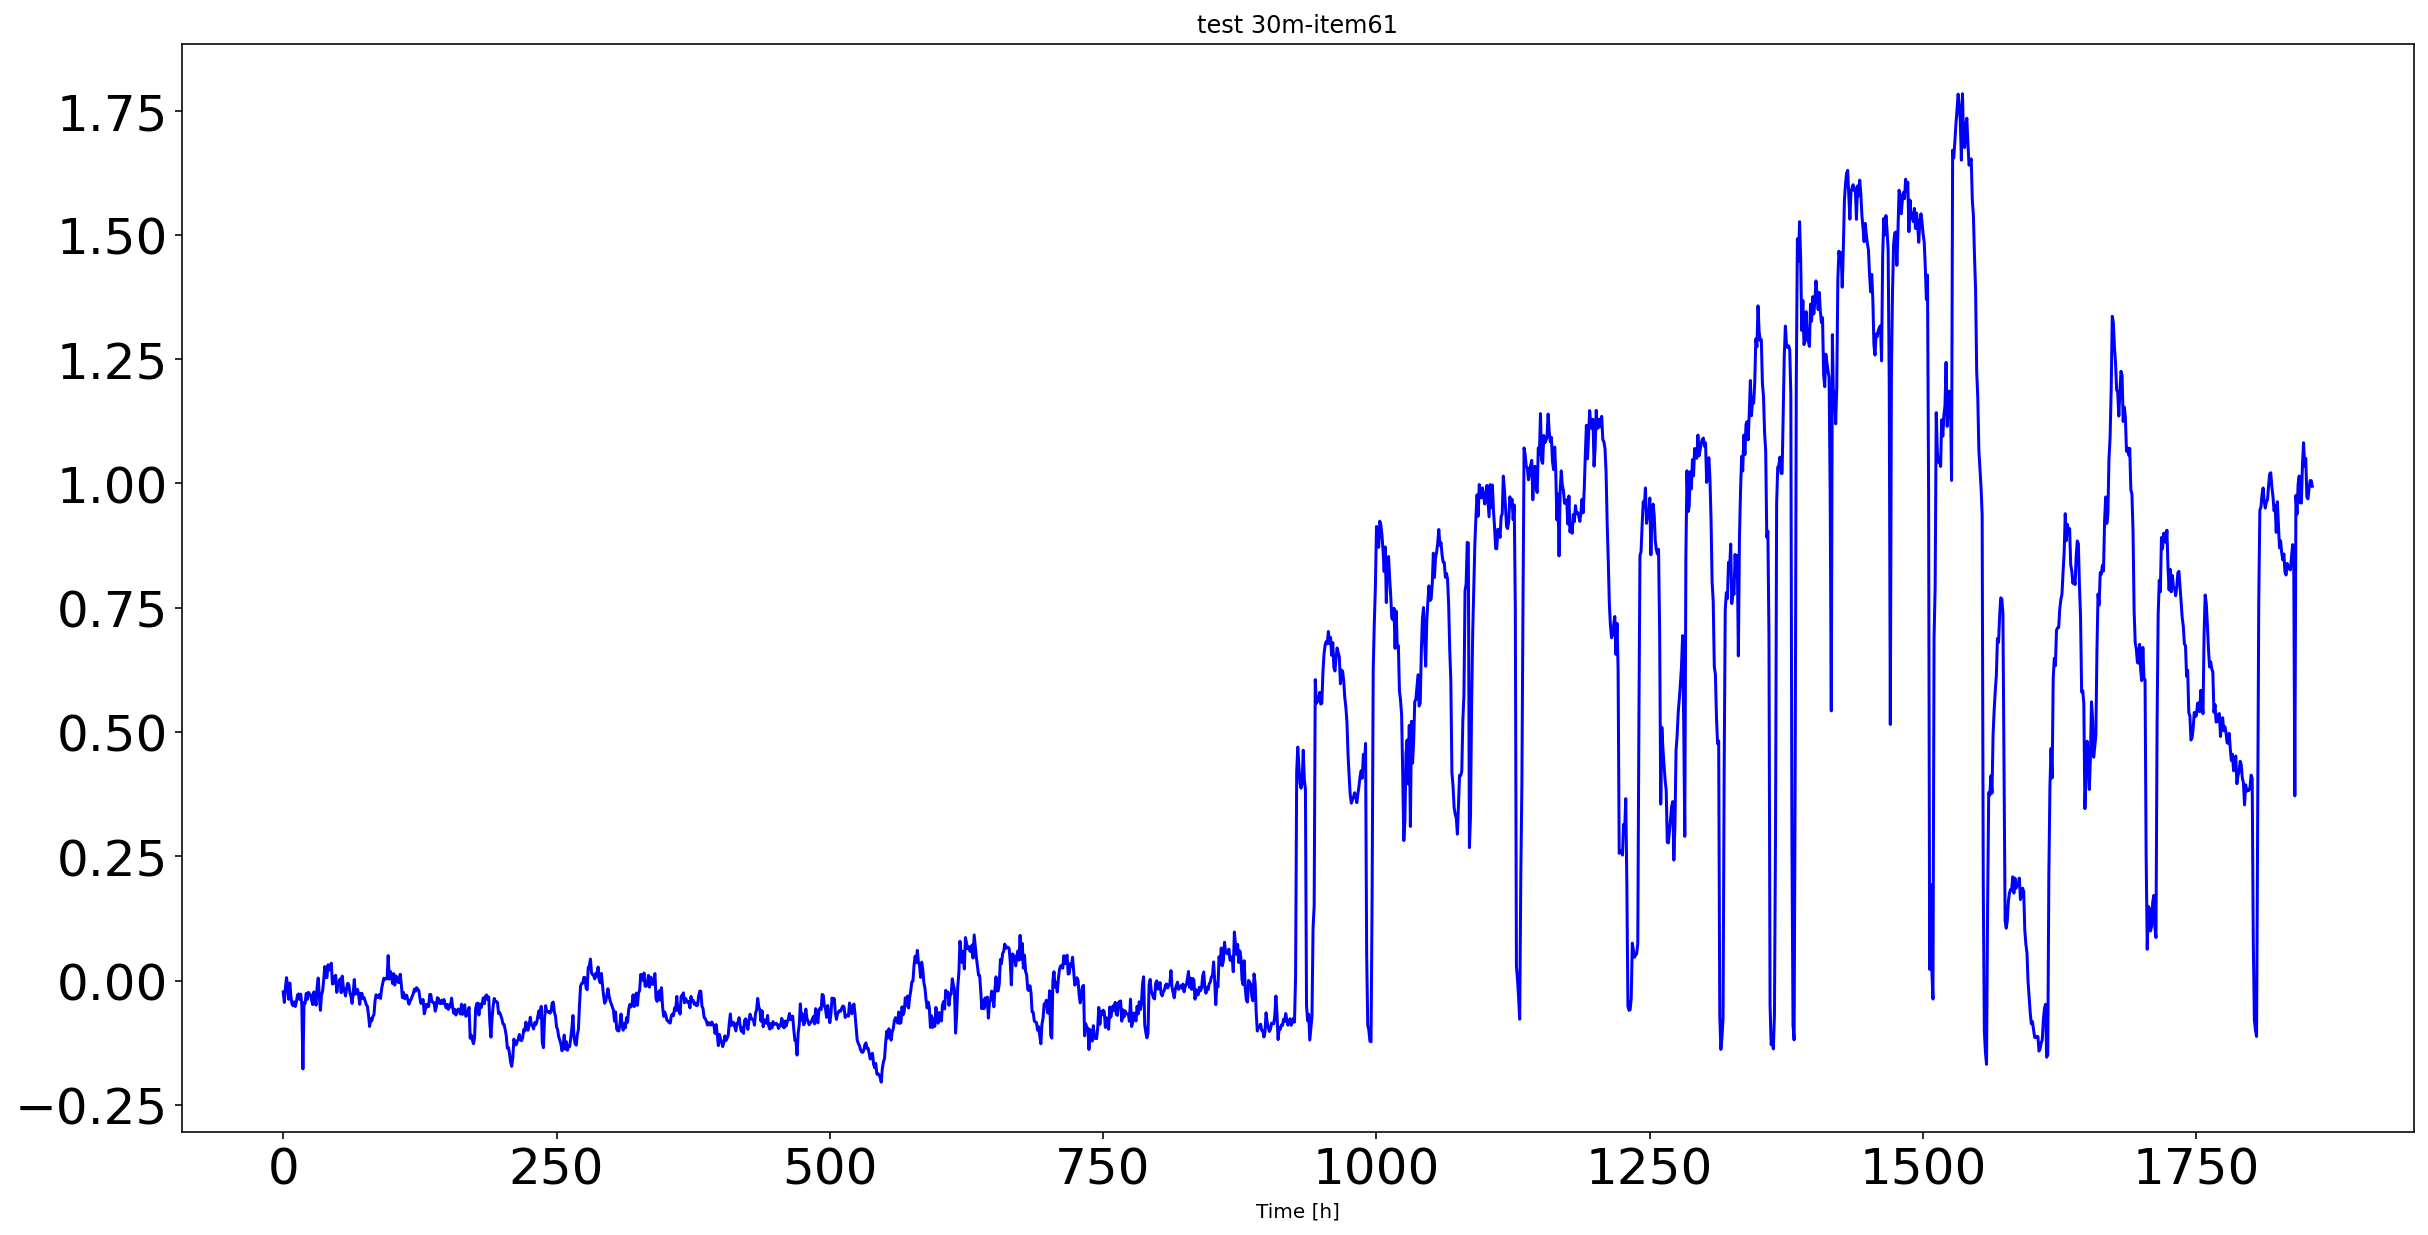

In [52]:
# plt.plot(X_valid_draw, "r")
plt.plot(X_valid, "b")
plt.xlabel('Time [h]')
plt.title('test 30m-item61')

In [50]:
X_train_norm, X_valid_norm = normalize(X_train, X_valid, 'q1_q3', 5)
rcParams['figure.figsize'] = 20, 10
# plt.plot(X_train_norm)
# plt.hlines(0,-50, len(X_train_norm)+50)



normalizing const = 6216.0


In [ ]:
# plt.plot(X_valid_norm)
# plt.hlines(0,-50, len(X_valid_norm)+50)


In [8]:
X_train_norm.shape

(15524,)

In [53]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i : (i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [54]:
X_t, Y_t = create_dataset(X_train_norm, 16)
X_v, Y_v = create_dataset(X_valid_norm, 16)
print(X_t.shape)
print(Y_t.shape)
print(X_v.shape)
print(Y_v.shape)

(15507, 16)
(15507,)
(1840, 16)
(1840,)


In [55]:
X_t = np.reshape(X_t, (X_t.shape[0], X_t.shape[1], 1))
X_v = np.reshape(X_v, (X_v.shape[0], X_v.shape[1], 1))
print(X_t.shape)
print(X_v.shape)


(15507, 16, 1)
(1840, 16, 1)


In [58]:
X_t[666]

array([[0.1256435 ],
       [0.11663449],
       [0.1204955 ],
       [0.10279923],
       [0.10891248],
       [0.11229086],
       [0.12065637],
       [0.10585585],
       [0.12725225],
       [0.11454312],
       [0.12146074],
       [0.11180824],
       [0.11261261],
       [0.10392535],
       [0.10086872],
       [0.10585585]], dtype=float32)

In [ ]:

# # split into train and test sets
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size : len(dataset), :]
# # reshape into X=t and Y=t+1
# look_back = 10
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)

# # reshape input to be [samples, time steps, features]
# trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# trainX = trainX.reshape((3553, 10, 1))
# testX = testX.reshape(((1745, 10, 1)))
# print(testX.shape)
# print(trainX.shape)
# print(trainY.shape)

In [ ]:
print(1)

In [56]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=512,
  input_shape=(X_t.shape[1], X_t.shape[2]),
    # return_sequences=True,
))
# model.add(keras.layers.LSTM(
#   units=128,
#   input_shape=(X_t.shape[1], X_t.shape[2]),
  
# ))
model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(0.0005)
)
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 512)               1052672   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [57]:
from tensorflow.keras.callbacks import ModelCheckpoint

ckpt = ModelCheckpoint(filepath="hist=16batch=128units=512", monitor='val_loss', mode='min', save_best_only = True, save_weights_only=True, verbose = False)


history = model.fit(
    X_t, Y_t,
    epochs=50,
    batch_size=128,
    validation_data=(X_v,Y_v),
    verbose=1,
    shuffle=False,
    # callbacks=[WandbCallback()]
)

# model.save(os.path.join(wandb.run.dir, "model1.h5"))

Epoch 1/50
122/122 [==============================] - 2s 13ms/step - loss: 0.0033 - val_loss: 0.0355
Epoch 2/50
122/122 [==============================] - 1s 11ms/step - loss: 0.0020 - val_loss: 0.0296
Epoch 3/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 0.0247
Epoch 4/50
122/122 [==============================] - 1s 11ms/step - loss: 0.0016 - val_loss: 0.0212
Epoch 5/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 0.0188
Epoch 6/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0171
Epoch 7/50
122/122 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 0.0159
Epoch 8/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0150
Epoch 9/50
122/122 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0144
Epoch 10/50
122/122 [==============================] - 1s 11ms/step - loss: 0.0013 - val_lo

In [ ]:
x_pred = model.predict(trainX)
y_pred = model.predict(testX)
print(len(x_pred[:,0]))
print(len(y_pred[:,0]))

In [ ]:
trainPredict = scaler.inverse_transform(x_pred)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(y_pred)
testY = scaler.inverse_transform([testY])
print(trainY)
print(testY)

In [ ]:
time = np.arange(0, len(dataset))

dataset1 = scaler.inverse_transform(dataset)
merged_list = []

for l in dataset1:
    merged_list.append(int(l[0]))
    
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=time, y=merged_list, mode="lines", name="povodne data",))
fig.add_trace(
    go.Scatter(
        x=time[look_back : len(trainPredict) + look_back],
        y=np.reshape(trainPredict, len(trainPredict)),
        mode="lines",
        name="treningova mnozina",
    )
)
fig.add_trace(
    go.Scatter(
        x=time[len(trainPredict) + (look_back * 2) + 1 : len(dataset) - 1],
        y=np.reshape(testPredict, len(testPredict)),
        mode="lines",
        name="testovacia mnozina",
    )
)
fig.show()

In [ ]:
print(1)

In [43]:
saved_models = "../saved_models/" + "30m-item61" + "/hist=" + "16batch=128units=512"
model.load_weights(saved_models)

OSError: Unable to open file (file read failed: time = Sun Aug  2 22:29:43 2020
, filename = '../saved_models/30m-item61/hist=16batch=128units=512', file descriptor = 70, errno = 21, error message = 'Is a directory', buf = 0x7fff6687bc60, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [38]:
!pwd

/home/kriza/programing/clanok/code
